In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Phemernr2-RNR"
unique_name = "BERT_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Phemernr2-RNR_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(6425, 768)

In [3]:
data = pd.read_csv("../../data/phemernr2_dataset_with_tvt.csv", sep=",")
data.head()

,tweet_id,tweet_text,label,tvt2,tvt2_1
0,552833795142209536,the east london mosque would like to offer its...,non-rumours,training,training
1,580318210609696769,breaking - a germanwings airbus a320 plane rep...,true,validation,testting
2,552798891994009601,reports that two of the dead in the #charliehe...,true,training,training
3,576790814942236672,after #putin disappeared russian tv no longer ...,non-rumours,validation,training
4,499678822598340608,saw #ferguson for myself. #justiceformichaelbr...,non-rumours,testting,testting


In [4]:
data['label'] = data['label'].replace(['true', 'unverfied', 'false'], 'rumours')

In [5]:
labels_str = ['rumours', 'non-rumours']
labels_str

['rumours', 'non-rumours']

In [6]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] == "rumours":
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [7]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [8]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(4336, 768)
(1462, 768)
(627, 768)
(4336,)
(1462,)
(627,)


In [9]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(5798, 768)


In [10]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(5798,)


In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str, fold: int):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [12]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 2-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 82.84482758620689
Saving after new best accuracy : 88.79310344827586
Saving after new best accuracy : 89.39655172413794
Saving after new best accuracy : 89.74137931034483
Saving after new best accuracy : 90.17241379310344
Saving after new best accuracy : 90.86206896551724
Saving after new best accuracy : 91.12068965517241
Saving after new best accuracy : 91.72413793103448
Saving after new best accuracy : 92.15517241379311
Saving after new best accuracy : 92.67241379310344
Saving after new best accuracy : 92.75862068965517
Saving after new best accuracy : 92.93103448275862
Saving after new best accuracy : 93.70689655172414
Saving after new best accuracy : 93.79310344827586
-- Epoch 50, Train_Accuracy : 93.27296248382923, Validation Accuracy : 93.27586206896552, Train Loss : 1.5391902290284634, Validation Loss : 0.5023435652256012
-- Epoch 100, Train_Accurac

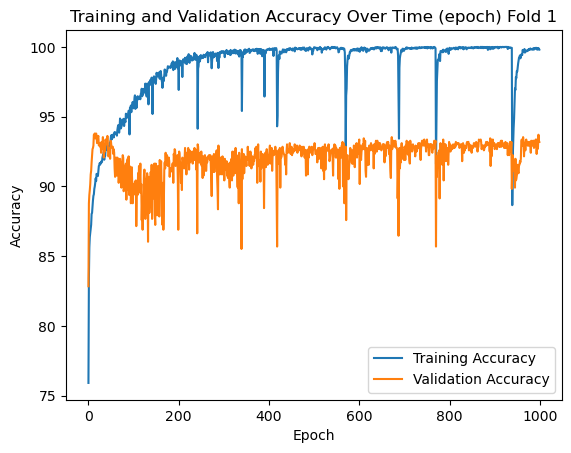

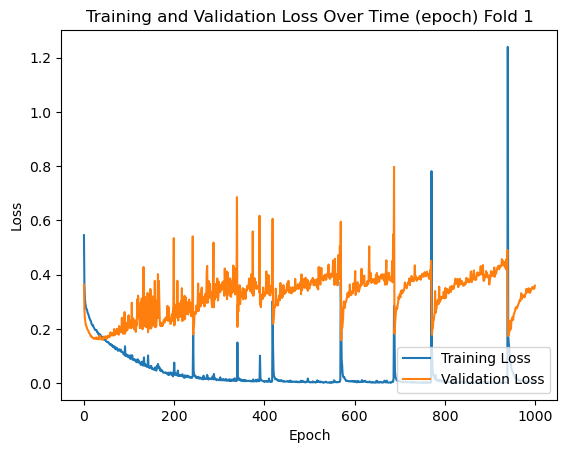

Exec Time : 72.29 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3083
False Positive : 116
False Negative : 324
True Negative : 1115

Class non-rumours Evaluation
- Precision : 96.374 %
- Recall : 90.49 %
- F1 : 0.93339

Class rumours Evaluation
- Precision : 77.484 %
- Recall : 90.577 %
- F1 : 0.83521

Combined Evaluation
- Accuracy : 90.513 %
- Precision : 86.929 %
- Recall : 90.533 %
- F1 : 0.88694
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold1 Train, 90.513, 86.929, 90.533, 0.88694, 96.374, 90.49, 0.93339, 77.484, 90.577, 0.83521, 
Confusion Matrix Scikit-learn: 
[[1115  116]
 [ 324 3083]]


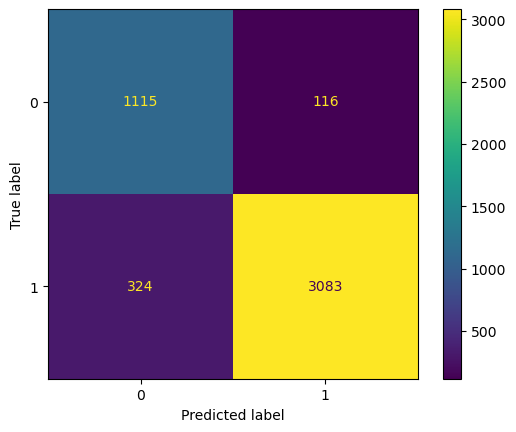


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 792
False Positive : 12
False Negative : 60
True Negative : 296

Class non-rumours Evaluation
- Precision : 98.507 %
- Recall : 92.958 %
- F1 : 0.95652

Class rumours Evaluation
- Precision : 83.146 %
- Recall : 96.104 %
- F1 : 0.89157

Combined Evaluation
- Accuracy : 93.793 %
- Precision : 90.827 %
- Recall : 94.531 %
- F1 : 0.92642
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold1 Validation, 93.793, 90.827, 94.531, 0.92642, 98.507, 92.958, 0.95652, 83.146, 96.104, 0.89157, 
Confusion Matrix Scikit-learn: 
[[296  12]
 [ 60 792]]


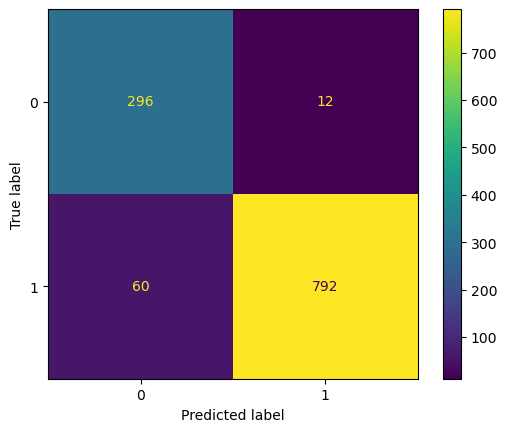


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 401
False Positive : 31
False Negative : 60
True Negative : 135

Class non-rumours Evaluation
- Precision : 92.824 %
- Recall : 86.985 %
- F1 : 0.8981

Class rumours Evaluation
- Precision : 69.231 %
- Recall : 81.325 %
- F1 : 0.74792

Combined Evaluation
- Accuracy : 85.486 %
- Precision : 81.027 %
- Recall : 84.155 %
- F1 : 0.82561
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold1 Test, 85.486, 81.027, 84.155, 0.82561, 92.824, 86.985, 0.8981, 69.231, 81.325, 0.74792, 
627
627
Confusion Matrix Scikit-learn: 
[[135  31]
 [ 60 401]]


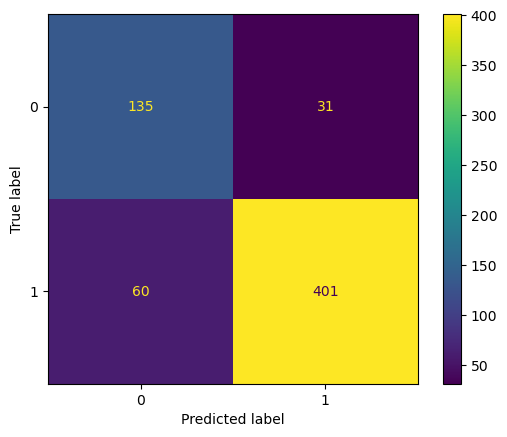

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 83.44827586206897
Saving after new best accuracy : 87.41379310344827
Saving after new best accuracy : 88.70689655172414
Saving after new best accuracy : 89.05172413793103
Saving after new best accuracy : 89.56896551724138
Saving after new best accuracy : 89.82758620689656
Saving after new best accuracy : 90.51724137931035
Saving after new best accuracy : 90.6896551724138
Saving after new best accuracy : 90.94827586206897
Saving after new best accuracy : 91.55172413793103
Saving after new best accuracy : 92.41379310344827
Saving after new best accuracy : 92.58620689655173
Saving after new best accuracy : 92.84482758620689
Saving after new best accuracy : 93.10344827586206
Saving after new best accuracy : 93.27586206896552
Saving after new best accuracy : 93.53448275862068
Saving after new best accuracy : 93.62068965517241
-- Epoch 50, Train_Accuracy : 92.82018111254851, Validation Accuracy : 93.1896551724138, Train Loss : 1.632

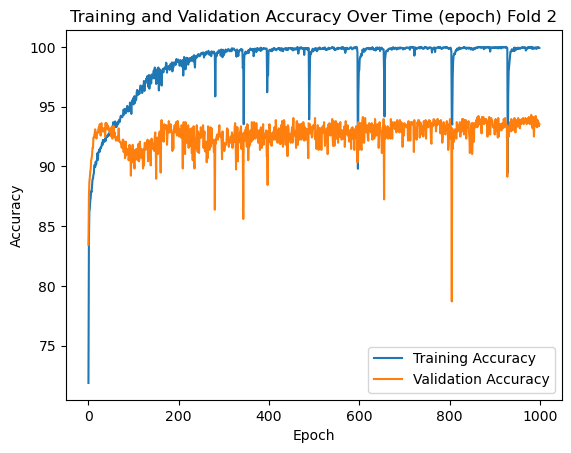

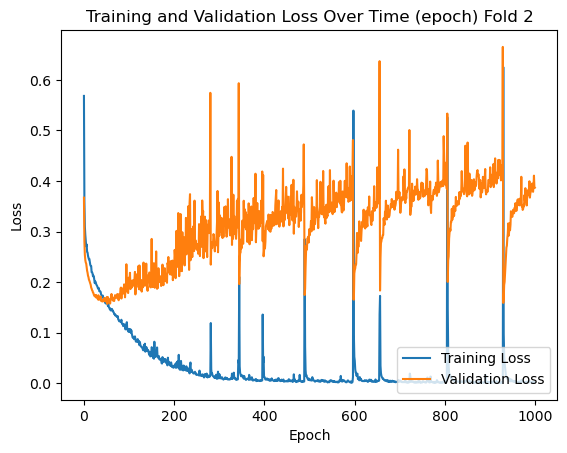

Exec Time : 56.49 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3407
False Positive : 0
False Negative : 0
True Negative : 1231

Class non-rumours Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumours Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold2 Train, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[1231    0]
 [   0 3407]]


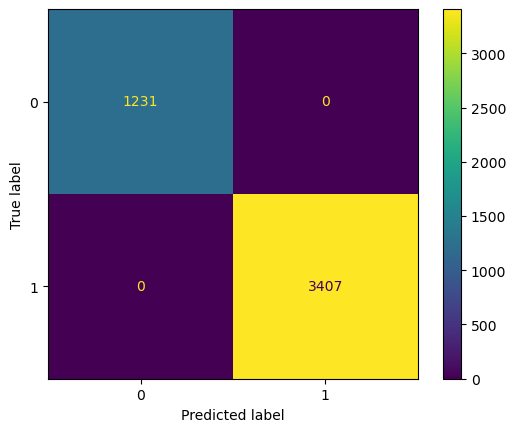


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 822
False Positive : 36
False Negative : 30
True Negative : 272

Class non-rumours Evaluation
- Precision : 95.804 %
- Recall : 96.479 %
- F1 : 0.9614

Class rumours Evaluation
- Precision : 90.066 %
- Recall : 88.312 %
- F1 : 0.8918

Combined Evaluation
- Accuracy : 94.31 %
- Precision : 92.935 %
- Recall : 92.395 %
- F1 : 0.92664
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold2 Validation, 94.31, 92.935, 92.395, 0.92664, 95.804, 96.479, 0.9614, 90.066, 88.312, 0.8918, 
Confusion Matrix Scikit-learn: 
[[272  36]
 [ 30 822]]


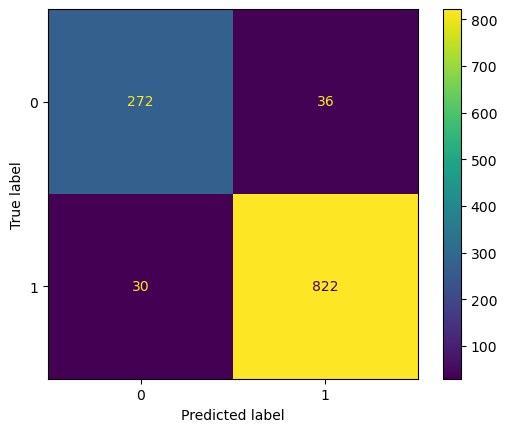


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 431
False Positive : 45
False Negative : 30
True Negative : 121

Class non-rumours Evaluation
- Precision : 90.546 %
- Recall : 93.492 %
- F1 : 0.91996

Class rumours Evaluation
- Precision : 80.132 %
- Recall : 72.892 %
- F1 : 0.76341

Combined Evaluation
- Accuracy : 88.038 %
- Precision : 85.339 %
- Recall : 83.192 %
- F1 : 0.84252
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold2 Test, 88.038, 85.339, 83.192, 0.84252, 90.546, 93.492, 0.91996, 80.132, 72.892, 0.76341, 
627
627
Confusion Matrix Scikit-learn: 
[[121  45]
 [ 30 431]]


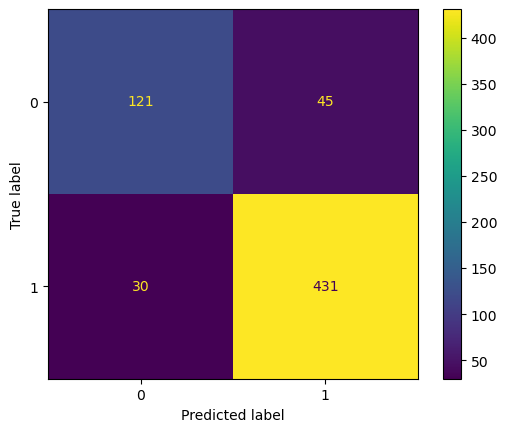

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 83.44827586206897
Saving after new best accuracy : 86.8103448275862
Saving after new best accuracy : 87.84482758620689
Saving after new best accuracy : 88.27586206896552
Saving after new best accuracy : 88.79310344827586
Saving after new best accuracy : 89.13793103448276
Saving after new best accuracy : 89.56896551724138
Saving after new best accuracy : 90.43103448275862
Saving after new best accuracy : 90.60344827586206
Saving after new best accuracy : 90.86206896551724
Saving after new best accuracy : 91.12068965517241
Saving after new best accuracy : 91.37931034482759
Saving after new best accuracy : 91.72413793103448
Saving after new best accuracy : 91.89655172413794
Saving after new best accuracy : 92.15517241379311
Saving after new best accuracy : 92.41379310344827
Saving after new best accuracy : 92.67241379310344
Saving after new best accuracy : 92.84482758620689
Saving after new best accuracy : 92.93103448275862
Savin

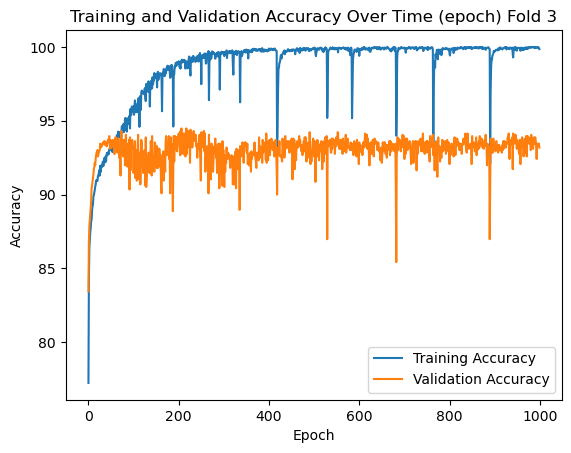

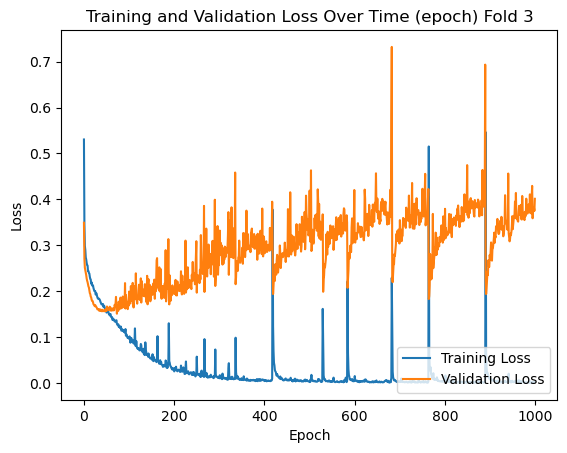

Exec Time : 56.46 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3389
False Positive : 6
False Negative : 18
True Negative : 1225

Class non-rumours Evaluation
- Precision : 99.823 %
- Recall : 99.472 %
- F1 : 0.99647

Class rumours Evaluation
- Precision : 98.552 %
- Recall : 99.513 %
- F1 : 0.9903

Combined Evaluation
- Accuracy : 99.483 %
- Precision : 99.188 %
- Recall : 99.492 %
- F1 : 0.9934
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold3 Train, 99.483, 99.188, 99.492, 0.9934, 99.823, 99.472, 0.99647, 98.552, 99.513, 0.9903, 
Confusion Matrix Scikit-learn: 
[[1225    6]
 [  18 3389]]


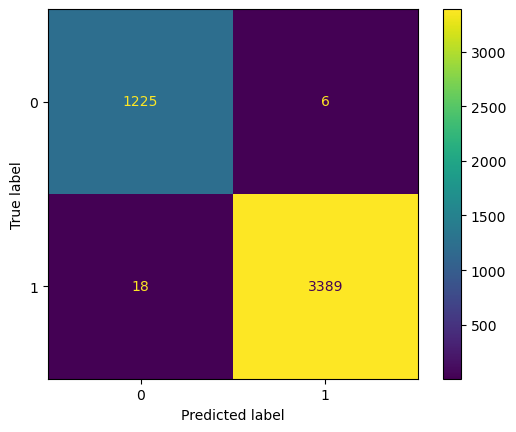


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 813
False Positive : 25
False Negative : 39
True Negative : 283

Class non-rumours Evaluation
- Precision : 97.017 %
- Recall : 95.423 %
- F1 : 0.96213

Class rumours Evaluation
- Precision : 87.888 %
- Recall : 91.883 %
- F1 : 0.89841

Combined Evaluation
- Accuracy : 94.483 %
- Precision : 92.452 %
- Recall : 93.653 %
- F1 : 0.93049
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold3 Validation, 94.483, 92.452, 93.653, 0.93049, 97.017, 95.423, 0.96213, 87.888, 91.883, 0.89841, 
Confusion Matrix Scikit-learn: 
[[283  25]
 [ 39 813]]


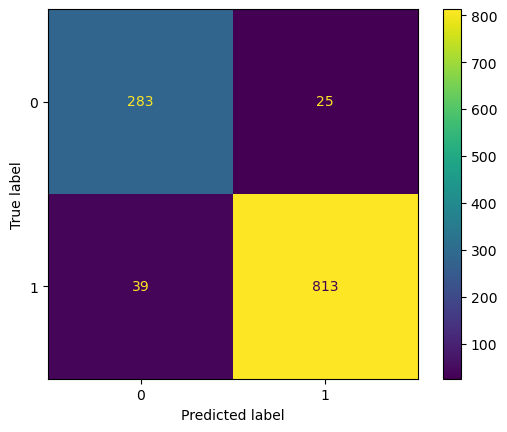


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 427
False Positive : 40
False Negative : 34
True Negative : 126

Class non-rumours Evaluation
- Precision : 91.435 %
- Recall : 92.625 %
- F1 : 0.92026

Class rumours Evaluation
- Precision : 78.75 %
- Recall : 75.904 %
- F1 : 0.77301

Combined Evaluation
- Accuracy : 88.198 %
- Precision : 85.092 %
- Recall : 84.264 %
- F1 : 0.84676
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold3 Test, 88.198, 85.092, 84.264, 0.84676, 91.435, 92.625, 0.92026, 78.75, 75.904, 0.77301, 
627
627
Confusion Matrix Scikit-learn: 
[[126  40]
 [ 34 427]]


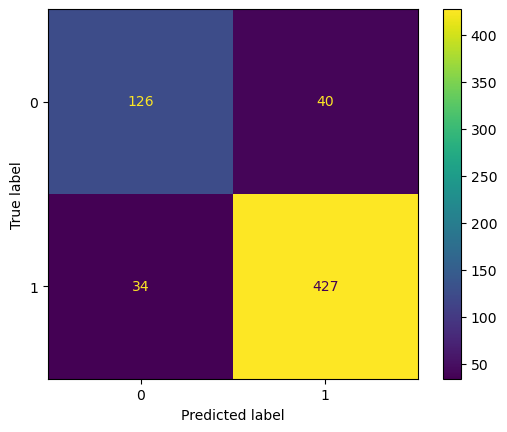

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 82.1397756686799
Saving after new best accuracy : 85.59102674719585
Saving after new best accuracy : 86.88524590163935
Saving after new best accuracy : 87.05780845556514
Saving after new best accuracy : 87.31665228645385
Saving after new best accuracy : 88.17946505608283
Saving after new best accuracy : 88.61087144089733
Saving after new best accuracy : 89.12855910267471
Saving after new best accuracy : 89.81880931837792
Saving after new best accuracy : 90.5090595340811
Saving after new best accuracy : 91.0267471958585
Saving after new best accuracy : 91.19930974978429
Saving after new best accuracy : 91.37187230371009
Saving after new best accuracy : 91.80327868852459
Saving after new best accuracy : 92.0621225194133
Saving after new best accuracy : 92.14840379637619
Saving after new best accuracy : 92.32096635030199
Saving after new best accuracy : 92.40724762726488
-- Epoch 50, Train_Accuracy : 93.44686354817848, Validation

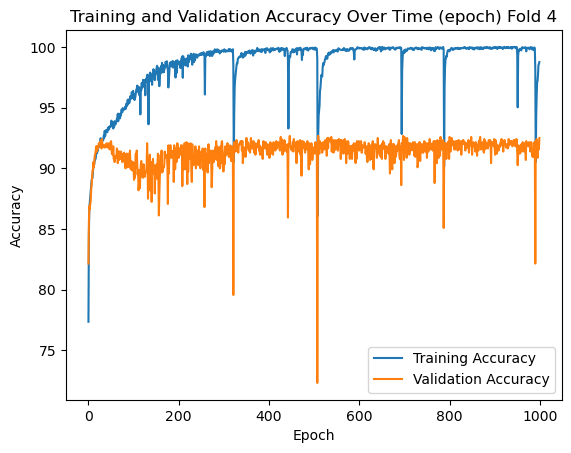

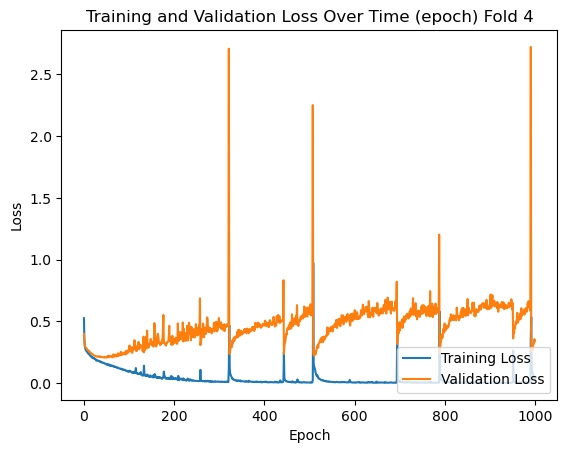

Exec Time : 64.68 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([4639])
Binary Class Evaluation

True Positive : 3406
False Positive : 0
False Negative : 1
True Negative : 1232

Class non-rumours Evaluation
- Precision : 100.0 %
- Recall : 99.971 %
- F1 : 0.99985

Class rumours Evaluation
- Precision : 99.919 %
- Recall : 100.0 %
- F1 : 0.99959

Combined Evaluation
- Accuracy : 99.978 %
- Precision : 99.959 %
- Recall : 99.985 %
- F1 : 0.99972
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold4 Train, 99.978, 99.959, 99.985, 0.99972, 100.0, 99.971, 0.99985, 99.919, 100.0, 0.99959, 
Confusion Matrix Scikit-learn: 
[[1232    0]
 [   1 3406]]


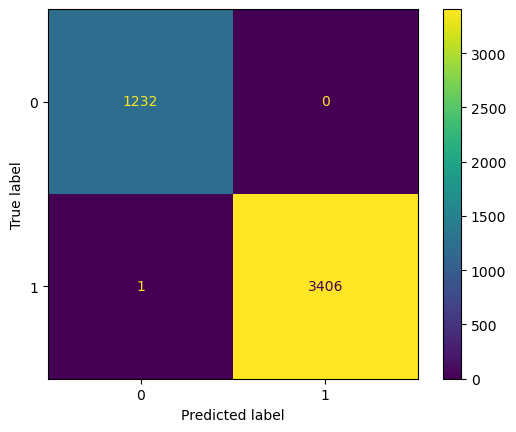


Validation Set
Predictions : torch.Size([1159])
Binary Class Evaluation

True Positive : 820
False Positive : 53
False Negative : 32
True Negative : 254

Class non-rumours Evaluation
- Precision : 93.929 %
- Recall : 96.244 %
- F1 : 0.95072

Class rumours Evaluation
- Precision : 88.811 %
- Recall : 82.736 %
- F1 : 0.85666

Combined Evaluation
- Accuracy : 92.666 %
- Precision : 91.37 %
- Recall : 89.49 %
- F1 : 0.9042
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold4 Validation, 92.666, 91.37, 89.49, 0.9042, 93.929, 96.244, 0.95072, 88.811, 82.736, 0.85666, 
Confusion Matrix Scikit-learn: 
[[254  53]
 [ 32 820]]


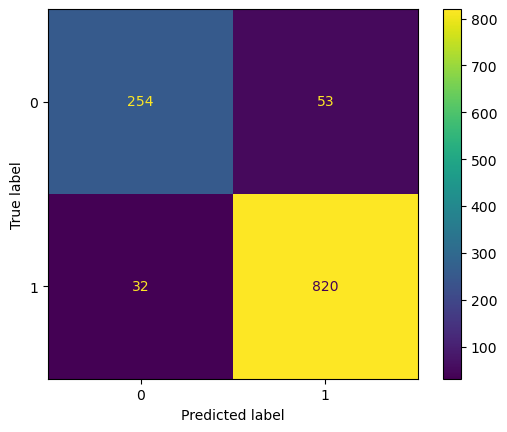


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 423
False Positive : 31
False Negative : 38
True Negative : 135

Class non-rumours Evaluation
- Precision : 93.172 %
- Recall : 91.757 %
- F1 : 0.92459

Class rumours Evaluation
- Precision : 78.035 %
- Recall : 81.325 %
- F1 : 0.79646

Combined Evaluation
- Accuracy : 88.995 %
- Precision : 85.603 %
- Recall : 86.541 %
- F1 : 0.86069
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold4 Test, 88.995, 85.603, 86.541, 0.86069, 93.172, 91.757, 0.92459, 78.035, 81.325, 0.79646, 
627
627
Confusion Matrix Scikit-learn: 
[[135  31]
 [ 38 423]]


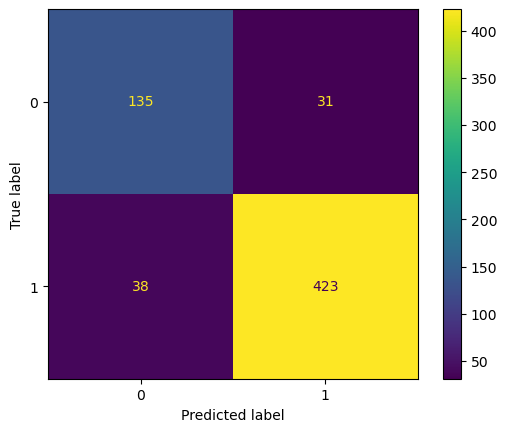

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 80.93183779119931
Saving after new best accuracy : 82.91630716134598
Saving after new best accuracy : 83.08886971527178
Saving after new best accuracy : 83.43399482312338
Saving after new best accuracy : 83.77911993097497
Saving after new best accuracy : 83.86540120793788
Saving after new best accuracy : 84.12424503882657
Saving after new best accuracy : 84.55565142364107
Saving after new best accuracy : 84.81449525452977
Saving after new best accuracy : 84.90077653149267
Saving after new best accuracy : 85.15962036238136
Saving after new best accuracy : 85.33218291630716
Saving after new best accuracy : 85.59102674719585
Saving after new best accuracy : 85.67730802415876
Saving after new best accuracy : 85.76358930112166
Saving after new best accuracy : 86.19499568593615
Saving after new best accuracy : 86.28127696289906
-- Epoch 50, Train_Accuracy : 94.6324638930804, Validation Accuracy : 85.93615185504746, Train Loss : 1.21

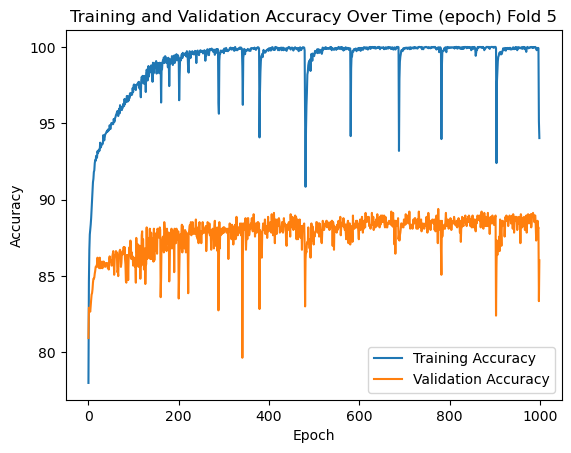

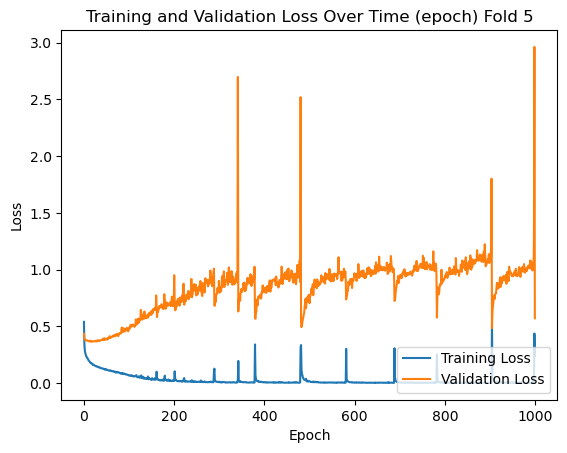

Exec Time : 54.6 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([4639])
Binary Class Evaluation

True Positive : 3408
False Positive : 0
False Negative : 0
True Negative : 1231

Class non-rumours Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumours Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold5 Train, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[1231    0]
 [   0 3408]]


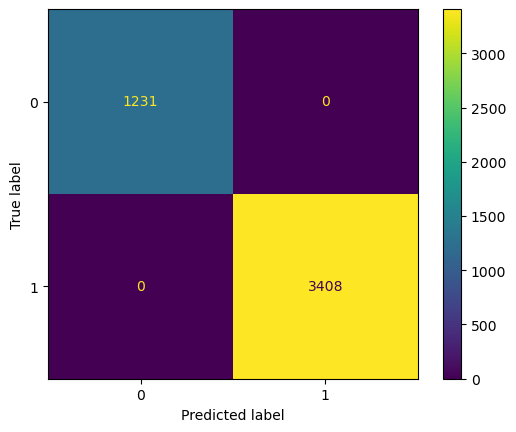


Validation Set
Predictions : torch.Size([1159])
Binary Class Evaluation

True Positive : 789
False Positive : 61
False Negative : 62
True Negative : 247

Class non-rumours Evaluation
- Precision : 92.824 %
- Recall : 92.714 %
- F1 : 0.92769

Class rumours Evaluation
- Precision : 79.935 %
- Recall : 80.195 %
- F1 : 0.80065

Combined Evaluation
- Accuracy : 89.387 %
- Precision : 86.379 %
- Recall : 86.455 %
- F1 : 0.86417
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold5 Validation, 89.387, 86.379, 86.455, 0.86417, 92.824, 92.714, 0.92769, 79.935, 80.195, 0.80065, 
Confusion Matrix Scikit-learn: 
[[247  61]
 [ 62 789]]


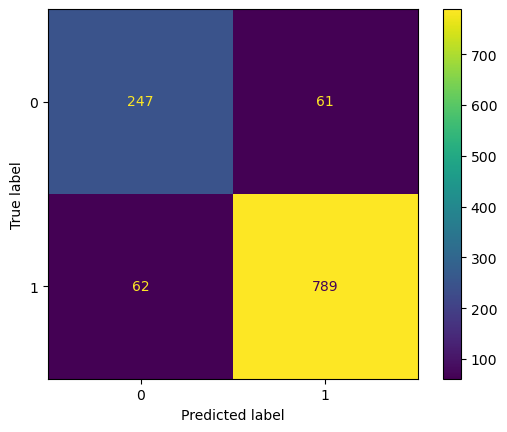


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 431
False Positive : 41
False Negative : 30
True Negative : 125

Class non-rumours Evaluation
- Precision : 91.314 %
- Recall : 93.492 %
- F1 : 0.9239

Class rumours Evaluation
- Precision : 80.645 %
- Recall : 75.301 %
- F1 : 0.77882

Combined Evaluation
- Accuracy : 88.676 %
- Precision : 85.979 %
- Recall : 84.397 %
- F1 : 0.85181
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_2LayerNet_L2Reg_BERT_Finetuned_Fold5 Test, 88.676, 85.979, 84.397, 0.85181, 91.314, 93.492, 0.9239, 80.645, 75.301, 0.77882, 
627
627
Confusion Matrix Scikit-learn: 
[[125  41]
 [ 30 431]]


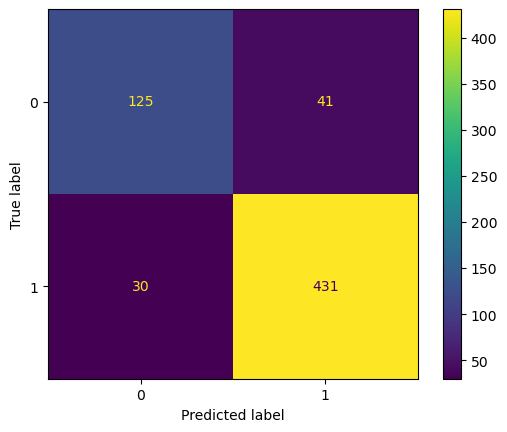

In [13]:
print("Multiclass Classification using 2-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_2LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()